# LAB3 - Uczenie sieci neuronowych z wykorzystaniem GPU
ver: 6

Przedmiot: _Sztuczna Inteligencja w Systemach Informatycznych_

Autor: Tomasz Szydło

kontakt: tszydlo@agh.edu.pl

Celem laboratorium jest porównanie czasu uczenia sieci neuronowych z wykorzystaniem CPU oraz GPU. Przedmiotem uczenia będzie sieć rozpoznająca cyfry pisane odręcznie. W procesie uczenia zostanie wykorzystany zbiór MNIST:

http://yann.lecun.com/exdb/mnist/


Laboratorium może być zrealizowane w dwóch środowiskach pracy:
 * Google Colab w chmurze obliczeniowej;
 * lokalnie na komputerze wyposażonym w GPU.


## Środowisko pracy - Google Codelab

https://codelabs.developers.google.com/?cat=Machine+Learning

Dostęp do notatnika: https://colab.research.google.com

Włączenie/wyłączenie wsparcia GPU odbywa się poprzez zmianę opcji środowiska uruchomieniowego:
 * Runtime -> Change runtime type -> Hardware accelerator -> None/GPU


## Środowisko pracy - PC + GPU/CUDA + Anaconda

Realizacja laboratorium wymaga Anacondy ze środowiskami:
 * tensorflow
 * tensorflow_gpuenv

Różnica pomiędzy nimi polega na wykorzystaniu implementacji biblioteki Tensorflow z NVidia CUDA.

Tworzenie środowisk:
 * wersja z CPU:

```
conda create -n tensorflow_env tensorflow
conda activate tensorflow_env
```

 * wersja z GPU:

```
conda create -n tensorflow_gpuenv tensorflow-gpu
conda activate tensorflow_gpuenv
```

Za pomocą Anaconda Navigator uruchamiamy Jupyter Notebook w konkretnym środowisku - tylko CPU lub ze wsparciem GPU.


## Sieć neuronowa dla zbioru MNIST

Przygotowanie środowiska - należy uruchomić notatnik z obliczeniami wyłącznie na CPU.

In [1]:
try:
    %tensorflow_version 2.x
except:
    pass

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, AveragePooling2D
from tensorflow.keras.utils import to_categorical

plt.rcParams['figure.figsize'] = (10, 10)  # Make the figures a bit bigger

In [3]:
physical_devices = tensorflow.config.list_physical_devices('GPU')
print("Num GPUs:", len(physical_devices))

Num GPUs: 1


In [4]:
nb_classes = 10

# the data, shuffled and split between tran and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)

X_train original shape (60000, 28, 28)
y_train original shape (60000,)


Zwizualizuj przykładowe dane.

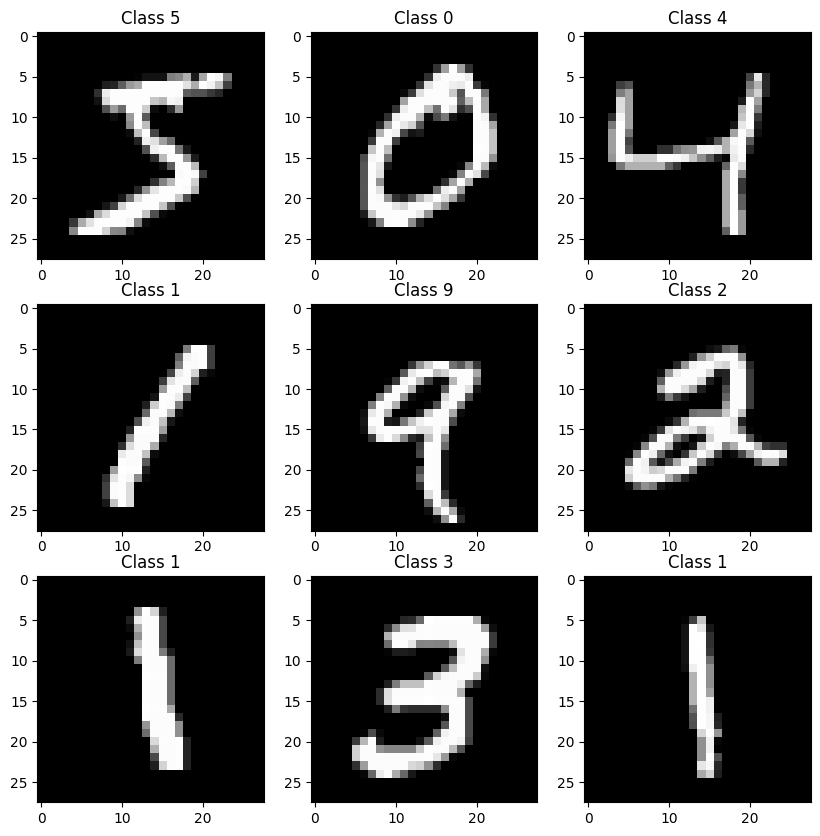

In [5]:
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_train[i], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[i]))

Sieć neuronowa przyjmuje na wejściu obrazek z jednym kanałem - poziomem jasności, więc konieczne jest przekształcenie danych wejściowych, aby każdy obraz 28 x 28 stał się macierzą 28 x 28 x 1.

Skalujemy również dane wejściowe w zakresie [0–1] zamiast [0–255]

In [6]:
X_train = X_train.reshape(60000, 28, 28, 1)
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


Zmodyfikuj macierze wyjść korzystając z techniki One Hot Encoding, tj.

```
0 -> [1, 0, 0, 0, 0, 0, 0, 0, 0]
1 -> [0, 1, 0, 0, 0, 0, 0, 0, 0]
2 -> [0, 0, 1, 0, 0, 0, 0, 0, 0]
```
itp.

In [7]:
Y_train = to_categorical(y_train, nb_classes)
Y_test = to_categorical(y_test, nb_classes)

# Sieć MLP
Zbuduj sieć neuronową. Na potrzeby zajęć sieć będzie posiadała 2 w pełni połączone warstwy. Na wejściu sieci jest macierz z jednym kanałem (28,28,1) dlatego pierwsza warstwa to *Flatten()*.

In [8]:
model_mlp = Sequential()
model_mlp.add(Flatten(input_shape=(28, 28,)))
model_mlp.add(Dense(512, input_shape=(784,)))
model_mlp.add(Activation('relu'))
model_mlp.add(Dropout(0.2))  # Dropout helps protect the model from memorizing or "overfitting" the training data

model_mlp.add(Dense(512))
model_mlp.add(Activation('relu'))
model_mlp.add(Dropout(0.2))

model_mlp.add(Dense(10))
model_mlp.add(Activation('softmax'))  # w celu zapewnienia rozkładu wyjść sumującego się do 1

# Sieć CNN
Zbuduj sieć neuronową. Powinna to być sieć LeNet-5 ze zmodyfikowanym rozmiarem wejścia (28,28,1) zamiast (32,32,1).

In [9]:
model_cnn = Sequential()
model_cnn.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model_cnn.add(AveragePooling2D())

model_cnn.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model_cnn.add(AveragePooling2D())

model_cnn.add(Flatten())
model_cnn.add(Dense(units=120, activation='relu'))
model_cnn.add(Dense(units=84, activation='relu'))
model_cnn.add(Dense(units=10, activation='softmax'))

# Kompilacja modelu

Kolejnym krokiem jest kompilacja modelu. Biblioteka Keras jest wysokopoziomowym API upraszczającym tworzenie i uczenie sieci neuronowych z wykorzystaniem biblitoeki Tensorflow. Podczas kompilacji sieci, biblioteka Keras wymaga określenia funkcji strat oraz algorytmu optymalizującego proces uczenia.

In [10]:
model_mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

In [12]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 6)         60        
                                                                 
 average_pooling2d (Average  (None, 13, 13, 6)         0         
 Pooling2D)                                                      
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 16)        880       
                                                                 
 average_pooling2d_1 (Avera  (None, 5, 5, 16)          0         
 gePooling2D)                                                    
                                                                 
 flatten_1 (Flatten)         (None, 400)               0         
                                                                 
 dense_3 (Dense)             (None, 120)              

Po kompilacji modelu sieci neuronowej można przystąpić do uczenia sieci. Ze względu na fakt, że Jupyter notebook został uruchomiony w środowisku z biblioteką Tensorflow bez wsparcia dla GPU, to obliczenia będą wykonywane tylko i wyłącznie na CPU.

In [13]:
import time
import keras


class TimeHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)


time_callback_mlp = TimeHistory()
time_callback_cnn = TimeHistory()

In [14]:
model_mlp_history = model_mlp.fit(X_train, Y_train,
                                  batch_size=128, epochs=16,
                                  verbose=1,
                                  validation_data=(X_test, Y_test), callbacks=time_callback_mlp)

Epoch 1/16
469/469 [==============================] - 10s 9ms/step - loss: 0.2466 - accuracy: 0.9271 - val_loss: 0.1016 - val_accuracy: 0.9676
Epoch 2/16
469/469 [==============================] - 2s 4ms/step - loss: 0.1019 - accuracy: 0.9693 - val_loss: 0.0789 - val_accuracy: 0.9750
Epoch 3/16
469/469 [==============================] - 2s 4ms/step - loss: 0.0731 - accuracy: 0.9767 - val_loss: 0.0678 - val_accuracy: 0.9782
Epoch 4/16
469/469 [==============================] - 2s 4ms/step - loss: 0.0557 - accuracy: 0.9826 - val_loss: 0.0699 - val_accuracy: 0.9799
Epoch 5/16
469/469 [==============================] - 2s 4ms/step - loss: 0.0464 - accuracy: 0.9849 - val_loss: 0.0681 - val_accuracy: 0.9784
Epoch 6/16
469/469 [==============================] - 2s 5ms/step - loss: 0.0383 - accuracy: 0.9874 - val_loss: 0.0677 - val_accuracy: 0.9799
Epoch 7/16
469/469 [==============================] - 2s 4ms/step - loss: 0.0350 - accuracy: 0.9883 - val_loss: 0.0680 - val_accuracy: 0.9819
Epoch

In [15]:
model_cnn_history = model_cnn.fit(X_train, Y_train,
                                  batch_size=128, epochs=16,
                                  verbose=1,
                                  validation_data=(X_test, Y_test), callbacks=time_callback_cnn)

Epoch 1/16
469/469 [==============================] - 6s 6ms/step - loss: 0.4037 - accuracy: 0.8798 - val_loss: 0.1313 - val_accuracy: 0.9618
Epoch 2/16
469/469 [==============================] - 2s 5ms/step - loss: 0.1091 - accuracy: 0.9675 - val_loss: 0.0698 - val_accuracy: 0.9787
Epoch 3/16
469/469 [==============================] - 2s 5ms/step - loss: 0.0751 - accuracy: 0.9764 - val_loss: 0.0618 - val_accuracy: 0.9785
Epoch 4/16
469/469 [==============================] - 2s 5ms/step - loss: 0.0597 - accuracy: 0.9815 - val_loss: 0.0512 - val_accuracy: 0.9841
Epoch 5/16
469/469 [==============================] - 3s 6ms/step - loss: 0.0503 - accuracy: 0.9849 - val_loss: 0.0485 - val_accuracy: 0.9839
Epoch 6/16
469/469 [==============================] - 2s 5ms/step - loss: 0.0423 - accuracy: 0.9872 - val_loss: 0.0356 - val_accuracy: 0.9883
Epoch 7/16
469/469 [==============================] - 2s 5ms/step - loss: 0.0371 - accuracy: 0.9889 - val_loss: 0.0372 - val_accuracy: 0.9874
Epoch 

In [16]:
times_mlp = time_callback_mlp.times
times_cnn = time_callback_cnn.times

print(f'Leaning time for MLP model: {times_mlp}')
print(f'Leaning time for CNN model: {times_cnn}')

Leaning time for MLP model: [10.285615682601929, 1.8391215801239014, 1.8472015857696533, 1.914470911026001, 1.910393238067627, 2.402330160140991, 1.8377411365509033, 1.9929378032684326, 1.8547513484954834, 2.0019819736480713, 1.9503614902496338, 2.513031482696533, 1.8677849769592285, 1.8764379024505615, 1.863940715789795, 2.0207862854003906]
Leaning time for CNN model: [5.753219842910767, 2.440962791442871, 2.425530433654785, 2.3592660427093506, 3.017098903656006, 2.1919867992401123, 2.365891456604004, 2.378760814666748, 2.492396831512451, 2.9765894412994385, 2.7411351203918457, 2.432559013366699, 2.6014280319213867, 2.468036651611328, 2.7700538635253906, 2.2497310638427734]


## Ewaluacja sieci neuronowej dla zbioru MNIST

In [17]:
def evaluate_model_and_plot(model, X_test, Y_test, y_test):
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score)

    predicted_classes = np.argmax(model.predict(X_test), axis=-1)
    correct_indices = np.nonzero(predicted_classes == y_test)[0]
    incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

    plt.figure()
    for i, correct in enumerate(correct_indices[:9]):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X_test[correct].reshape(28, 28), cmap='gray', interpolation='none')
        plt.title("Predicted {}, Class {}".format(predicted_classes[correct], y_test[correct]))

    plt.figure()
    for i, incorrect in enumerate(incorrect_indices[:9]):
        plt.subplot(3, 3, i + 1)
        plt.imshow(X_test[incorrect].reshape(28, 28), cmap='gray', interpolation='none')
        plt.title("Predicted {}, Class {}".format(predicted_classes[incorrect], y_test[incorrect]))

Test score: [0.07755433022975922, 0.9829999804496765]
313/313 [==============================] - 1s 2ms/step


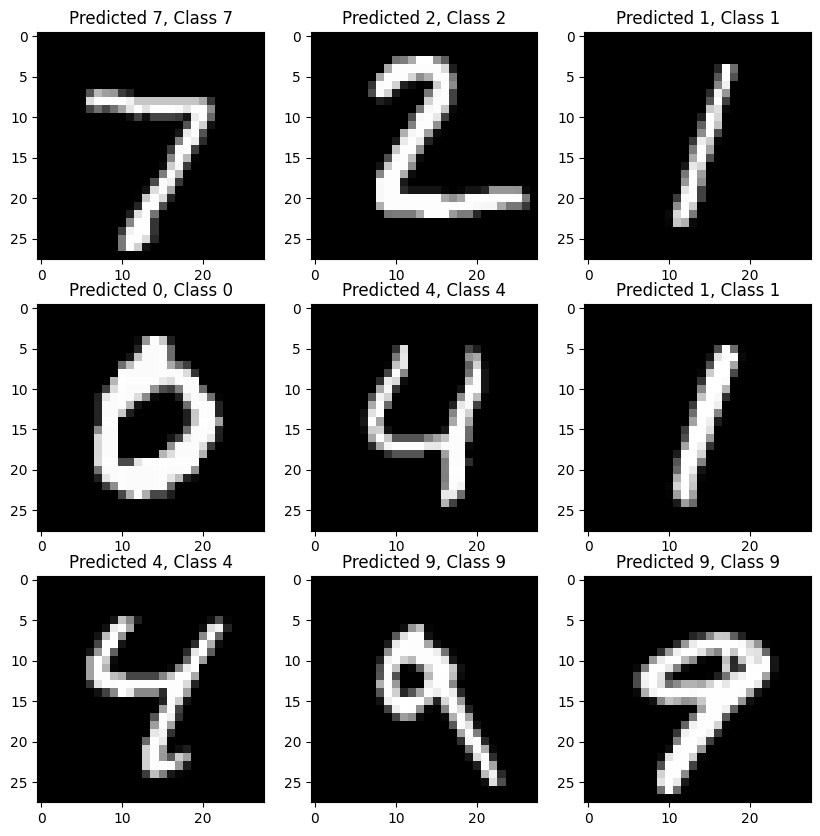

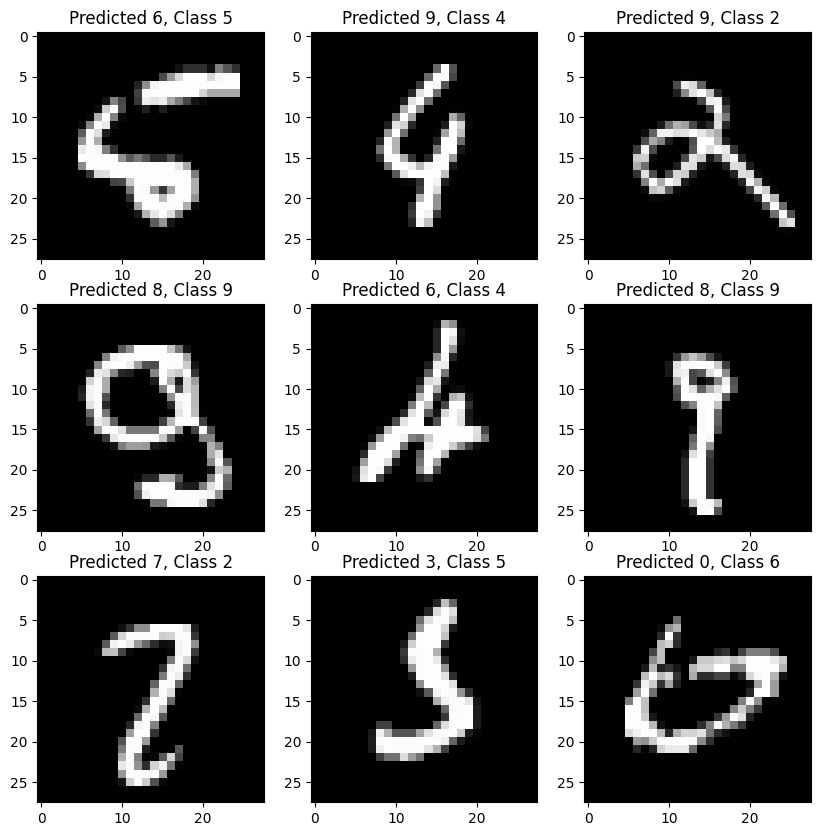

In [18]:
evaluate_model_and_plot(model_mlp, X_test, Y_test, y_test)

Test score: [0.032069142907857895, 0.989300012588501]
313/313 [==============================] - 1s 2ms/step


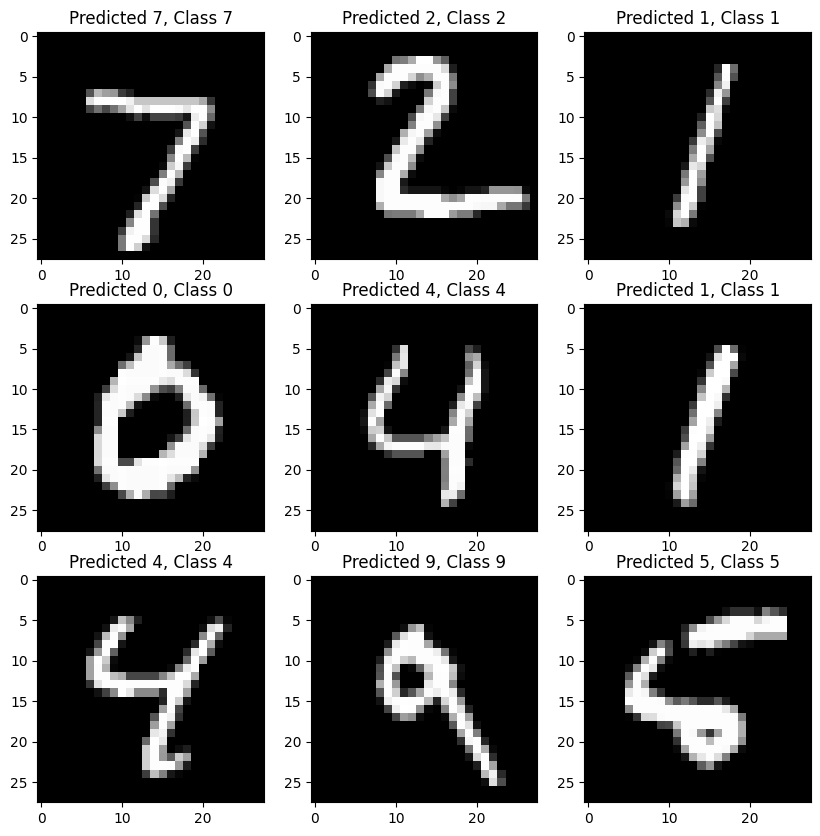

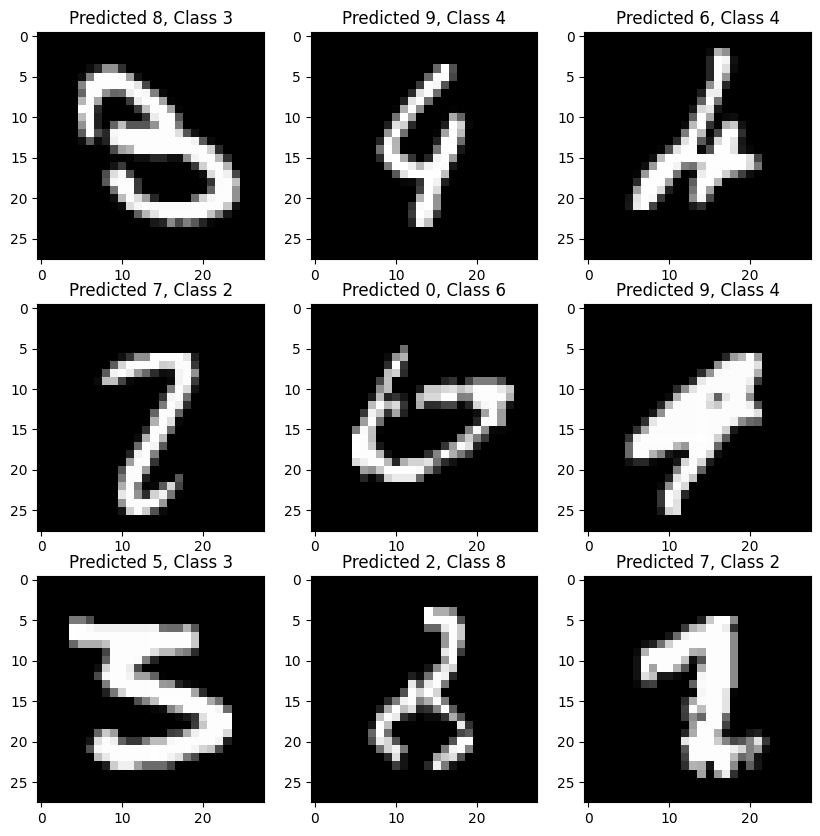

In [19]:
evaluate_model_and_plot(model_cnn, X_test, Y_test, y_test)

## Analiza czasu uczenia sieci z wykorzystaniem CPU oraz przy wsparciu GPU

Uzupełnij poniższy fragment kodu wpisując dane dotyczące czasu obliczeń dla każdej z szesnastu epok uczenia sieci neuronowej.

In [20]:
# cpu_epoch_time_MLP = times_mlp
# cpu_accuracy_MLP = model_mlp_history.history['accuracy']
cpu_epoch_time_MLP = [11.222673416137695, 9.183462619781494, 10.083718299865723, 10.25218415260315, 10.350078344345093,
                      10.198598861694336, 9.99060344696045, 10.286441802978516, 10.40776777267456, 10.432920217514038,
                      10.214941501617432, 9.595431566238403, 10.56038784980774, 10.855984449386597, 10.770994663238525,
                      11.066787481307983]
cpu_accuracy_MLP = [0.9256666898727417, 0.9692500233650208, 0.977733314037323, 0.981416642665863, 0.9856666922569275,
                    0.9871500134468079, 0.9878666400909424, 0.9900833368301392, 0.9906666874885559, 0.9914500117301941,
                    0.9928666949272156, 0.992900013923645, 0.9928833246231079, 0.9931833148002625, 0.993066668510437,
                    0.994949996471405]

# cpu_epoch_time_CNN = times_cnn
# cpu_accuracy_CNN = model_cnn_history.history['accuracy']
cpu_epoch_time_CNN = [18.46142029762268, 18.125458240509033, 16.943353414535522, 17.573923110961914, 17.477396965026855,
                      16.85967230796814, 18.93330430984497, 17.205277681350708, 17.18299174308777, 18.359525680541992,
                      17.258448123931885, 18.494547367095947, 16.89707636833191, 17.185132265090942, 18.033103704452515,
                      17.368638277053833]
cpu_accuracy_CNN = [0.8792499899864197, 0.9642666578292847, 0.9745833277702332, 0.9797666668891907, 0.9829833507537842,
                    0.9854999780654907, 0.9868833422660828, 0.9881666898727417, 0.989983320236206, 0.9907166957855225,
                    0.9913166761398315, 0.9921833276748657, 0.9930499792098999, 0.9935166835784912, 0.994350016117096,
                    0.9952999949455261]

Uaktywnij wsparcie GPU dla obliczeń i uruchom ponownie proces uczenia sieci neuronowej na bazie MNIST i uzupełnij fragment kodu poniżej.

W przypadku środowiska Anaconda zamknij środowisko *tensorflow\_env* i uruchom środowisko *tensorflow\_gpuenv*. W przypadku Google Colab zmień ustawienia środowiska uruchomieniowego.



In [21]:
gpu_epoch_time_MLP = times_mlp
gpu_accuracy_MLP = model_mlp_history.history['accuracy']

gpu_epoch_time_CNN = times_cnn
gpu_accuracy_CNN = model_cnn_history.history['accuracy']

Zwizualizuj i przeanalizuj czas uczenia sieci neuronowej z CPU i GPU.

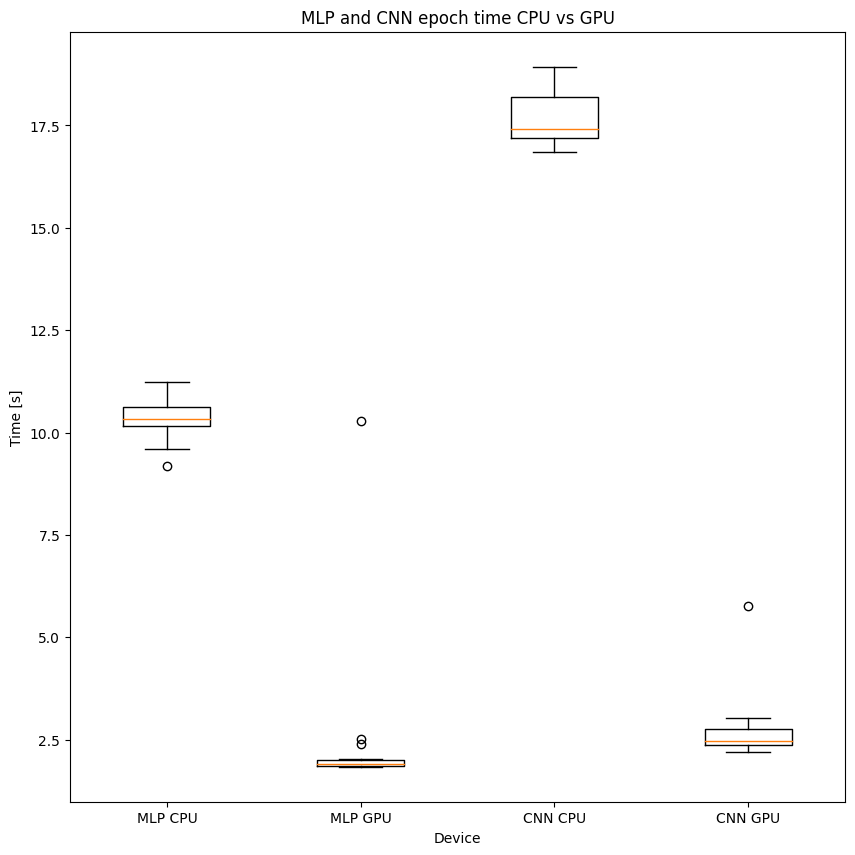

In [22]:
plt.boxplot([cpu_epoch_time_MLP, gpu_epoch_time_MLP, cpu_epoch_time_CNN, gpu_epoch_time_CNN],
            labels=['MLP CPU', 'MLP GPU', 'CNN CPU', 'CNN GPU'])
plt.title('MLP and CNN epoch time CPU vs GPU')
plt.xlabel('Device')
plt.ylabel('Time [s]')
plt.show()

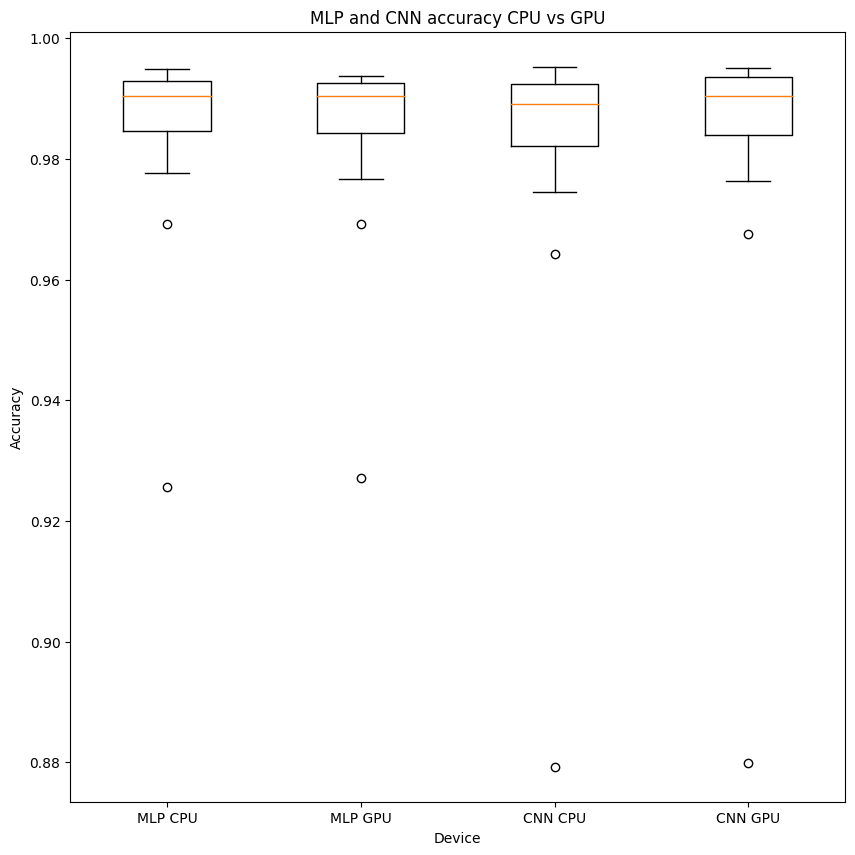

In [23]:
plt.boxplot([cpu_accuracy_MLP, gpu_accuracy_MLP, cpu_accuracy_CNN, gpu_accuracy_CNN],
            labels=['MLP CPU', 'MLP GPU', 'CNN CPU', 'CNN GPU'])
plt.title('MLP and CNN accuracy CPU vs GPU')
plt.xlabel('Device')
plt.ylabel('Accuracy')
plt.show()

**Wnioski**

**Przeanalizuj różnicę pomiędzy czasem obliczeń dla CPU i GPU oraz osiągniętą jakością sieci neuronowej.**

Różnice między czasem obliczeń dla CPU i GPU są znaczące. W przypadku GPU czas uczenia sieci neuronowej jest znacznie krótszy. W przypadku jakości sieci neuronowej różnice są znikome. Można zauwazyć, że sieć CNN osiąga lepsze accuracy niż sieć MLP, jednak jest to związane z większą złożonością sieci przez co CNN jest wolniejsze niż MLP w przypadku CPU i GPU.


**W przypadku korzystania z własnej karty GPU podaj specyfikację techniczną komputera i karty graficznej.**

 - Hardware model: Dell Inspiron 15 7000 Gaming
 - CPU: Intel Core i5-7300HQ x 4
 - Memory: 16 GB